# Finding Adjacent Frequency Signals from Different On-Sky Targets

Noah Stiegler

7/8/24

## Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import Angle
from astropy.table import Table
from astropy.time import Time
import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array


In [2]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

In [3]:
coherent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2984740 entries, 0 to 31107169
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   signal_frequency         float64       
 2   signal_drift_rate        float64       
 3   signal_snr               float64       
 4   signal_beam              int64         
 5   signal_power             float64       
 6   signal_incoherent_power  float64       
 7   signal_num_timesteps     int64         
 8   tstart                   float64       
 9   tstart_h                 datetime64[ns]
 10  ra_hours                 float64       
 11  dec_degrees              float64       
 12  source_name              object        
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 318.8+ MB


## New Approach

So I realized the old approach (algorithm 1) was needlessly complicated and slow. The actual comparisons I wanted to do were in the "window finding" function, so I just adapted that routine into the full algorithm here

##### Get the data

In [4]:
# Just try this out with data from the first timestamp to see if it works
first_time = coherent["tstart"][0]
test_data = coherent[coherent["tstart"] == first_time]
test_data.reset_index(drop=True, inplace=True) # Important so the indices are consecutive

# Cut down the data to just the frequency
fs = test_data["signal_frequency"] # fs is frequencies

##### Set Threshold


In [5]:
# For the comparisons
threshold_hz = 100
threshold = threshold_hz * 1e-6

##### Check what the traditional distance method yields

In [6]:
def traditional_method(fs, threshold):
    a = fs.to_numpy().reshape(1, -1)
    b = fs.to_numpy().reshape(-1, 1)
    true_distances = abs(a - b)
    true_distances[np.tril_indices(len(fs), k=0)] = np.nan
    truly_within_threshold = (true_distances <= threshold)
    return true_distances, truly_within_threshold

true_distances, truly_within_threshold = traditional_method(fs, threshold)
print(true_distances.shape)
print(true_distances[:5, :5])
num_distances = len(fs)**2 - np.isnan(true_distances).sum()
print(f"{num_distances} points are not NaN of {len(fs)**2} ({round(num_distances / (len(fs)**2), 4)}%)")

(1800, 1800)
[[       nan 0.24833679 0.21554947 0.4553051  0.39719772]
 [       nan        nan 0.03278732 0.70364189 0.64553452]
 [       nan        nan        nan 0.67085457 0.61274719]
 [       nan        nan        nan        nan 0.05810738]
 [       nan        nan        nan        nan        nan]]
1619100 points are not NaN of 3240000 (0.4997%)


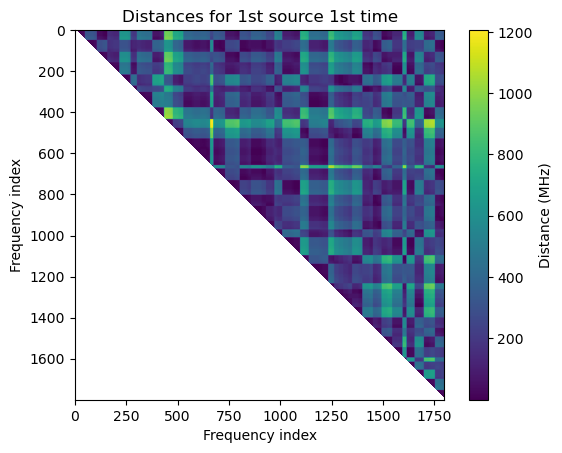

In [7]:
# Show the distances
plt.imshow(true_distances)
cbar = plt.colorbar(label="Distance (MHz)")
plt.xlabel("Frequency index")
plt.ylabel("Frequency index")
plt.title("Distances for 1st source 1st time")
plt.show()

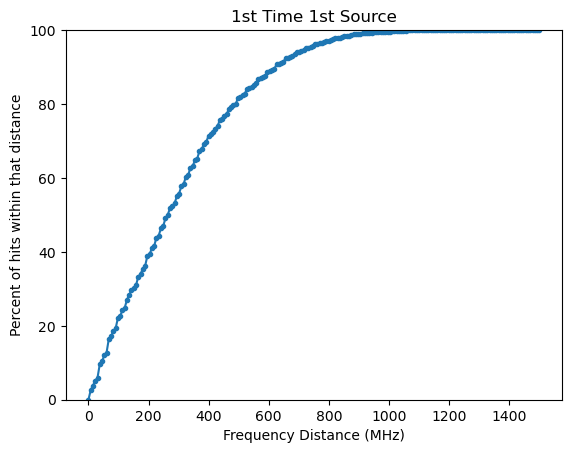

In [8]:
# Look at percent over a certain distance
xaxis = np.linspace(0, 1.5e9, 200) * 1e-6
yaxis = [((true_distances <= x).sum() / num_distances) * 100 for x in xaxis]
plt.plot(xaxis, yaxis, marker='.')
plt.ylim([0, 100])
plt.xlabel("Frequency Distance (MHz)")
plt.ylabel("Percent of hits within that distance")
plt.title("1st Time 1st Source")
plt.show()

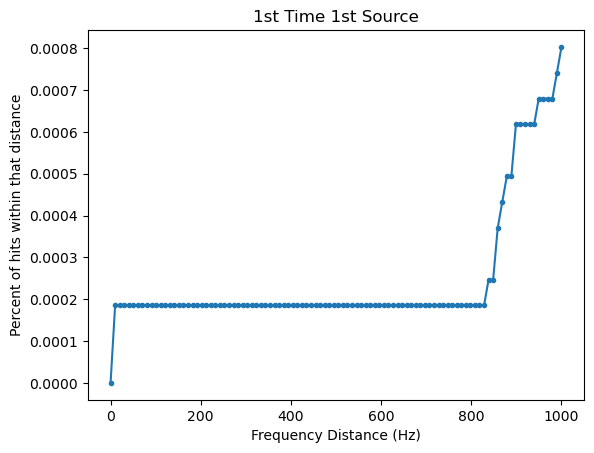

In [9]:
# Same but for smaller distances
xaxis = np.linspace(0, 1000, 100)
yaxis = [((true_distances <= x * 1e-6 ).sum() / num_distances) * 100 for x in xaxis]
plt.plot(xaxis, yaxis, marker='.')
# plt.ylim([0, 100])
plt.xlabel("Frequency Distance (Hz)")
plt.ylabel("Percent of hits within that distance")
plt.title("1st Time 1st Source")
plt.show()

In [10]:
# Check what the indices of the ones within a threshold are
truly_within_threshold = (true_distances <= threshold)
print(f"{truly_within_threshold.sum()} ({round(truly_within_threshold.sum() / num_distances * 100, 3)}%) are within {threshold * 1e6}hz")
print(truly_within_threshold.nonzero())

3 (0.0%) are within 99.99999999999999hz
(array([ 84,  86, 576]), array([703, 706, 638]))


##### New Approach

In [11]:
# Find adjacent points (like algorithm described above)
# data: pandas series with reset index (index goes 0...n-1 consecutively)
# window_width: width of window to find adjacency in same units as data (ie MHz and MHz)
# Returns:
# (distances, mask) tuple
# distances is a scipy sparse lil_array of float distances between adjacent points
# mask is a scipy sparse lil_array of booleans indicating whether 
def find_adjacent_distances(data, window_width):
    # Sort the data by frequency
    sdata = data.sort_values() # sfs is sorted frequencies
    # Make sure to keep track of the original indices
    original_indices = sdata.index # Maps index in sfs to index in fs

    # Setup empty arrays, indices are original indices of data
    num_hits = len(data)
    mask = lil_array((num_hits, num_hits), dtype=bool) 
    distances = lil_array((num_hits, num_hits), dtype=np.float32) 

    # Find which hits are adjacent in order. Stop if we find one that isn't
    for i, datum in enumerate(sdata):
        j = i + 1 # Index of point to compare to
        while ((j < num_hits) and # Don't index off the end of the array
               (abs(sdata.iloc[j] - datum) <= window_width)): 
            # Find coordinates in the non-sorted list
            u = original_indices[i]
            v = original_indices[j]

            # Make sure it's upper triangular (might have to flip over diagonal)
            if u > v: u, v = v, u # swap u and v
            
            # Set elements in matrix
            mask[u, v] = True
            distances[u, v] = abs(sdata.iloc[j] - datum)

            # Check next point
            j += 1

    # Return data
    return distances, mask

distances, mask = find_adjacent_distances(fs, threshold)

In [12]:
# Look at the ([rows], [columns]) where elements are
print(mask.nonzero())
print(distances.nonzero())

(array([ 84,  86, 576], dtype=int32), array([703, 706, 638], dtype=int32))
(array([ 84,  86, 576], dtype=int32), array([703, 706, 638], dtype=int32))


##### Compare to traditional approach

In [13]:
# Compare to traditional approach
print("Algorithm")
print(mask.nonzero())
print(distances.nonzero())
print("Matrices")
print(truly_within_threshold.nonzero())

Algorithm
(array([ 84,  86, 576], dtype=int32), array([703, 706, 638], dtype=int32))
(array([ 84,  86, 576], dtype=int32), array([703, 706, 638], dtype=int32))
Matrices
(array([ 84,  86, 576]), array([703, 706, 638]))


In [14]:
# Check everything is all good non-visually
mask_indices = mask.nonzero()
distances_indices = distances.nonzero()
traditional_indices = truly_within_threshold.nonzero()
for i in [0, 1]:
    assert(np.array_equal(mask_indices[i], distances_indices[i]) and np.array_equal(mask_indices[i], traditional_indices[i]))

In [15]:
print(f"And the distances which are under {threshold * 1e6}hz are:")
print(true_distances[truly_within_threshold] * 1e6)
print("so it looks like there's some kind of frequency resolution around ~.8hz and 3 pairs of points are within that")
print("And the frequencies are:")
i_sames, j_sames = truly_within_threshold.nonzero()
for k in range(len(i_sames)):
    i = i_sames[k]
    j = j_sames[k]
    print(f"{round(fs.iloc[i], 6)}MHz & {round(fs.iloc[j], 6)}MHz")

And the distances which are under 99.99999999999999hz are:
[0.83308987 0.83308987 0.83308987]
so it looks like there's some kind of frequency resolution around ~.8hz and 3 pairs of points are within that
And the frequencies are:
42935.81259MHz & 42935.81259MHz
42938.877205MHz & 42938.877206MHz
42879.999909MHz & 42879.999908MHz


##### Look at what results are 

And the distances which are under 99.99999999999999hz are:
[0.83308987 0.83308987 0.83308987]
so it looks like there's some kind of frequency resolution around ~.8hz and 3 pairs of points are within that
and then there are also some points which are within like 1000hz of each other


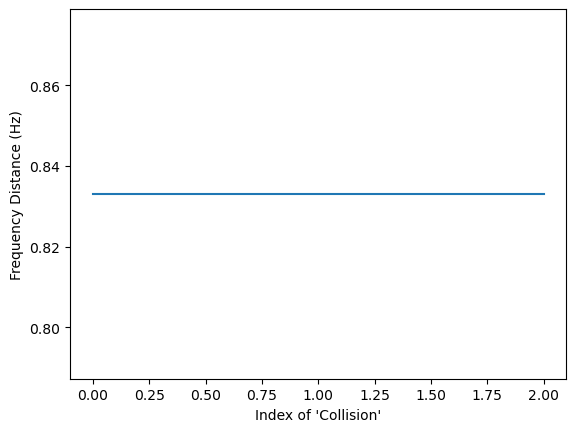

In [16]:
print(f"And the distances which are under {threshold * 1e6}hz are:")
print(true_distances[truly_within_threshold] * 1e6)
print("so it looks like there's some kind of frequency resolution around ~.8hz and 3 pairs of points are within that")
print("and then there are also some points which are within like 1000hz of each other")

plt.plot(true_distances[truly_within_threshold] * 1e6)
plt.ylabel("Frequency Distance (Hz)")
plt.xlabel("Index of 'Collision'")
plt.show()

In [17]:
print("And the frequencies are:")
i_sames, j_sames = truly_within_threshold.nonzero()
for k in range(len(i_sames)):
    i = i_sames[k]
    j = j_sames[k]
    f_i = fs.iloc[i]
    f_j = fs.iloc[j]
    print(f"{round(f_i, 6)}MHz & {round(f_j, 6)}MHz")

And the frequencies are:
42935.81259MHz & 42935.81259MHz
42938.877205MHz & 42938.877206MHz
42879.999909MHz & 42879.999908MHz


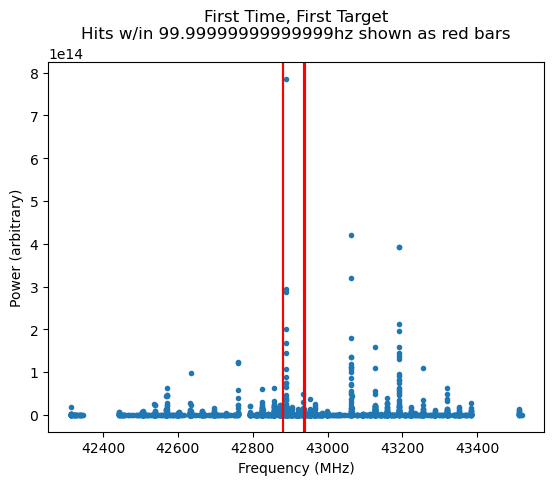

In [18]:
# Scatter all the points in frequency and power
plt.scatter(test_data["signal_frequency"], test_data["signal_power"], marker='.')

i_sames, j_sames = truly_within_threshold.nonzero()
for k in range(len(i_sames)):
    i = i_sames[k]
    j = j_sames[k]
    f_i = fs.iloc[i]
    f_j = fs.iloc[j]
    plt.axvline(f_i, c='r')
    plt.axvline(f_j, c='r')

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (arbitrary)")
plt.title(f"First Time, First Target\nHits w/in {threshold * 1e6}hz shown as red bars")
plt.show()

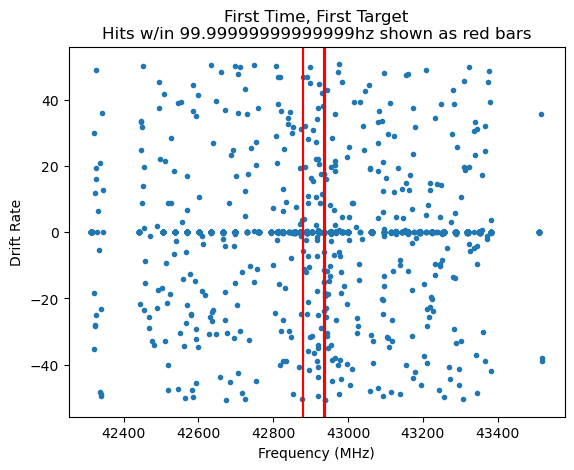

In [19]:
# Scatter all the points in frequency and power
plt.scatter(test_data["signal_frequency"], test_data["signal_drift_rate"], marker='.')

i_sames, j_sames = truly_within_threshold.nonzero()
for k in range(len(i_sames)):
    i = i_sames[k]
    j = j_sames[k]
    f_i = fs.iloc[i]
    f_j = fs.iloc[j]
    plt.axvline(f_i, c='r')
    plt.axvline(f_j, c='r')

plt.xlabel("Frequency (MHz)")
plt.ylabel("Drift Rate")
plt.title(f"First Time, First Target\nHits w/in {threshold * 1e6}hz shown as red bars")
plt.show()

In [22]:
i_sames, j_sames = truly_within_threshold.nonzero()
ids = test_data["id"]
for k in range(len(i_sames)):
    i = i_sames[k]
    j = j_sames[k]
    f_i = fs.iloc[i]
    f_j = fs.iloc[j]
    print(ids.iloc[i], ids.iloc[j])

900273311 900274434
900273349 900274437
900274211 900274328


##### Benchmark to see which way takes longer

Setup three datasets to benchmark performance on. We have the first dataset we had been running on, which is the first target at the first time (1800 hits). We'll also look at the first 10k hits on the first source, and then all hits on the first source (71k hits)

In [20]:
# Setup other datasets to augment the small one
datasets = [fs.copy()]

# Get all data from the first source
first_source = coherent["source_name"][0]
all_test_data = coherent[coherent["source_name"] == first_source].reset_index(drop=True)

# Setup medium datasets to test on
for size in [10_000, 20_000, 40_000]:
    subset_test_data = all_test_data[:size].copy().reset_index(drop=True)
    datasets.append(subset_test_data["signal_frequency"])

# Do all data at the end
datasets.append(all_test_data["signal_frequency"])

# Look at how long the datasets are
dataset_lengths = [len(dataset) for dataset in datasets]
print("Testing on:", dataset_lengths)

Testing on: [1800, 10000, 20000, 40000, 71425]


In [21]:
# Setup functions to benchmark
def benchmark_matrix(dataset, threshold):
    print(f"Benchmarking with matrix method on size: {len(dataset)}")
    time = %timeit -o true_distances, truly_within_threshold = traditional_method(dataset, threshold)
    return time

def benchmark_algorithm(dataset, threshold):
    print(f"Benchmarking with algorithm method on size: {len(dataset)}")
    time = %timeit -o distances, mask = find_adjacent_distances(dataset, threshold)
    return time

# Setup containers to hold results
matrix_results = [benchmark_matrix(dataset, threshold) for dataset in datasets]
algorithm_results = [benchmark_algorithm(dataset, threshold) for dataset in datasets]

Benchmarking with matrix method on size: 1800
28.8 ms ± 378 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Benchmarking with matrix method on size: 10000
1.13 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Benchmarking with matrix method on size: 20000
4.52 s ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Benchmarking with matrix method on size: 40000


KeyboardInterrupt: 

In [ ]:
# Get results as times
matrix_averages = np.array([result.average for result in matrix_results])
algorithm_averages = np.array([result.average for result in algorithm_results])

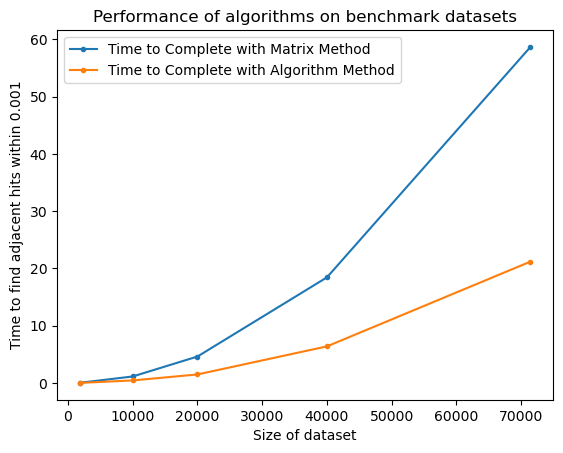

In [ ]:

# Graph results
plt.plot(dataset_lengths, matrix_averages, 
         marker='.', label="Time to Complete with Matrix Method")
plt.plot(dataset_lengths, algorithm_averages,
         marker='.', label="Time to Complete with Algorithm Method")

# Make labels
plt.title("Performance of algorithms on benchmark datasets")
plt.xlabel("Size of dataset")
plt.ylabel(f"Time to find adjacent hits within {threshold}")
plt.legend()

# Change scale
# plt.xscale("log")
# plt.yscale("log")

plt.show()

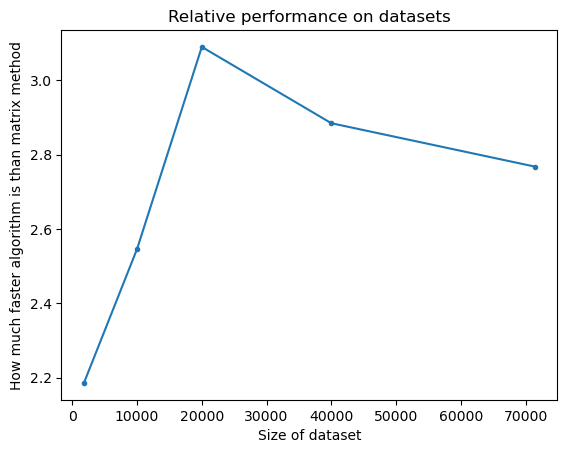

In [ ]:
# Graph ratio
plt.plot(dataset_lengths, matrix_averages / algorithm_averages, 
         marker='.')

# Make labels
plt.title("Relative performance on datasets")
plt.xlabel("Size of dataset")
plt.ylabel(f"How much faster algorithm is than matrix method")
# plt.legend()

# Change scale
# plt.xscale("log")
# plt.yscale("log")

plt.show()